In [1]:
#import stuffs

import numpy as np
from scipy.spatial import Voronoi, voronoi_plot_2d
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from random import randint
import random

In [2]:
#borrowed from https://gist.github.com/pv/8036995

def voronoi_finite_polygons_2d(vor, radius=None):
    """
    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.
    Parameters
    ----------
    vor : Voronoi
        Input diagram
    radius : float, optional
        Distance to 'points at infinity'.
    Returns
    -------
    regions : list of tuples
        Indices of vertices in each revised Voronoi regions.
    vertices : list of tuples
        Coordinates for revised Voronoi vertices. Same as coordinates
        of input vertices, with 'points at infinity' appended to the
        end.
    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()*2

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)



In [3]:
def vine(top, bot, amp, width, omega, res, size, data, inval, x_shift, rand):
    
    '''vine takes in a ton of floats and outputs a list of verticies that define the vine as a polygon.
    top is a float for the max height of the center vine (mm) (some leaves may be taller!)
    bot is a float for the minimum of the vine, no leaves will be lower (mm)
    amp is the amplitude of the sine wave that definse the vine (mm)
    width is how thick the vine is (mm)
    omega is how fast the vine oscilates (rad/mm)
    res is the size of vertical steps (mm)
    size is the size of leaves
    data is a list of 1, 2, and 3's that define the pattern of leaves (1 is left leaf, 2 is right leaf, 3 is both)
    inval is the the number of steps (whose size is defined by res) between leaves
    x_shift is a shift in the x direction from center at x = 0
    rand is the coeficent of randomness added to the leaf co-ordinates, if it is 1 they can change by plus or minus 0.5mm
    '''
    
    #Paramaters
    interval = inval*res
    
    random.seed(271) #make deterministic
    
    #Leaf param
    side1 = 0.25*np.array([1,0])*size
    side2 = 0.125*np.array([3,1])*size
    side3 = 0.5*np.array([1,2])*size
    side4 = 0.25*np.array([-2,-1])*size
    side5 = 0.125*np.array([-1,-3])*size

    #generate vine spine
    spine = []
    for i in np.linspace(bot,top,int(1 + (top-bot)/res)):
        spine.append([amp/2*np.sin(i * omega)+x_shift, i])

    verts = []

    #Work up the right side, adding leaves as needed
    counter = 0
    for i in spine:
        x = i[0]
        y = i[1]
        if len(data) <= counter:
            counter = 0
        if (i[1]%interval) == 0: 
            if (data[counter] == 3 or data[counter] == 2):
                #Leaf time lets go
                noise =  list([(random.random()-0.5)*rand, + (random.random()-0.5)*rand])
                noise = np.array(noise)
                current = [x+width/2, y] + noise
                verts.append(current)
                noise =  list([(random.random()-0.5)*rand, + (random.random()-0.5)*rand])
                noise = np.array(noise)
                current = current + side1 + noise
                verts.append(current)
                noise =  list([(random.random()-0.5)*rand, + (random.random()-0.5)*rand])
                noise = np.array(noise)
                current = current + side2 + noise
                verts.append(current)
                noise =  list([(random.random()-0.5)*rand, + (random.random()-0.5)*rand])
                noise = np.array(noise)
                current = current + side3 + noise
                verts.append(current)
                noise =  list([(random.random()-0.5)*rand, + (random.random()-0.5)*rand])
                noise = np.array(noise)
                current = current + side4 + noise
                verts.append(current)
                noise =  list([(random.random()-0.5)*rand, + (random.random()-0.5)*rand])
                noise = np.array(noise)
                current = current + side5 + noise
                verts.append(current)
                verts.append( [x+width/2,y])
            counter += 1
        else:
            verts.append( [x+width/2,y])

    #down
    counter = len(data) - counter
    data = list(reversed(data))
    for i in reversed(spine):
        x = i[0]
        y = i[1]
        if len(data) <= counter:
            counter = 0
        if (i[1]%interval)< 0.5*res:
            if (data[counter] == 3 or data[counter] == 1):
                #LEAF TIME
                noise =  list([(random.random()-0.5)*rand, + (random.random()-0.5)*rand])
                noise = np.array(noise)
                current = [x+width/2,y] + noise
                verts.append(current)
                noise =  list([(random.random()-0.5)*rand, + (random.random()-0.5)*rand])
                noise = np.array(noise)
                current = current - np.array([1,-1])*side1 + noise
                verts.append(current)
                noise =  list([(random.random()-0.5)*rand, + (random.random()-0.5)*rand])
                noise = np.array(noise)
                current = current - np.array([1,-1])*side2 + noise
                verts.append(current)
                noise =  list([(random.random()-0.5)*rand, + (random.random()-0.5)*rand])
                noise = np.array(noise)
                current = current - np.array([1,-1])*side3 + noise
                verts.append(current)
                noise =  list([(random.random()-0.5)*rand, + (random.random()-0.5)*rand])
                noise = np.array(noise)
                current = current - np.array([1,-1])*side4 + noise
                verts.append(current)
                noise =  list([(random.random()-0.5)*rand, + (random.random()-0.5)*rand])
                noise = np.array(noise)
                current = current - np.array([1,-1])*side5 + noise
                verts.append(current)
                verts.append( [x+width/2,y])
            counter += 1
        else:
            verts.append( [x+width/2,y])

    return verts

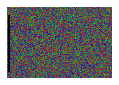

In [7]:
# generates Points
x = 36+1 #length of x axis, 1mm more than frame for mounting
dx = .2 #x size of average grain
y = 24+1 #length of y axis, 1mm more than frame for mounting
dy = .2 #average y meassure of grain
p = .8 #chance of an out of sequence color
alpha = 1 #transparency

random.seed(271) #make deterministic
plt.figure(figsize=(x*0.0393700787,y*0.0393700787)) 

points = []
for i in np.linspace(0,x,int(x/dx+1)):
    for j in np.linspace(0,y,int(y/dy+1)):
        rand_x = random.random()
        rand_x *= dx
        rand_y = random.random()
        rand_y *= dy
        points.append([rand_x+i,rand_y+j])

vor = Voronoi(points)


# generate regions
regions, vertices = voronoi_finite_polygons_2d(vor)

# colorize and plot
counter = 0
for region in regions:
    color = [0,0,0]
    color[counter%3] = 1
    counter += 1
    if random.random()>p:
        counter +=1
        
    polygon = vertices[region]
    plt.fill(*zip(*polygon), color = color, alpha=alpha)

# black out, makes sure we only see the frame
points = np.array([[0,0],[0,y],[-10,y],[-10,0]])
plt.fill(points[:,0],points[:,1],'k')
points = np.array([[x,0],[x,y],[x+10,y],[x+10,0]])
plt.fill(points[:,0],points[:,1],'k')


# make calibraiton marks
polygon = vine(22,2,0.25,0.25,3.89,0.25,0.15,[1,1,2,3],3, 0.5, .025)    
plt.fill(*zip(*polygon), color = 'black', alpha=alpha)

#plt.plot(points[:,0], points[:,1], 'ko')

plt.axis('equal')
plt.xlim([0, x])
plt.ylim([0, y])
plt.axis('off')

#copied from https://stackoverflow.com/questions/11837979/removing-white-space-around-a-saved-image
#to get it to fill whole image
plt.gca().set_axis_off()
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())

#saving as a .png or .svg
plt.savefig('vine_RGB_0.2_1.png', dpi=1200,bbox_inches='tight',pad_inches = 0)
plt.show()